# 05. Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)
*Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.*



## What we're going to cover

We're going to go through the follow with TensorFlow:

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
- Using the Keras Functional API (a differnt way to build models in Keras)
- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
- Data augmentation (how to make your training dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data
  - **Model 0**: a transfer learning model using the Keras Functional API
  - **Model 1**: a feature extraction transfer learning model on 1% of the data with data augmentation
  - **Model 2**: a feature extraction transfer learning model on 10% of the data with data augmentation
  - **Model 3**: a fine-tuned transfer learning model on 10% of the data
  - **Model 4**: a fine-tuned transfer learning model on 100% of the data
- Introduce the ModelCheckpoint callback to save intermediate training results
- Compare model experiments results using TensorBoard


In [1]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

2025-01-17 06:40:25.482922: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 06:40:30.683674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-17 06:40:32.577534: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-17 06:40:33.096942: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 06:40:36.739711: I tensorflow/core/platform/cpu_feature_guar

TensorFlow version: 2.17.0


In [2]:
# Are we using a GPU?
!nvidia-smi

Fri Jan 17 06:41:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    On  |   00000000:65:00.0 Off |                  N/A |
| N/A   47C    P0             12W /   77W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Creating helper functions

Throughout your machine learning experiments, you'll likely come across snippets of code you want to use over and over again.

For example, a plotting function which plots a model's `history` object (see `plot_loss_curves()` below).

You could recreate these functions over and over again.

But as you might've guessed, rewritting the same functions becomes tedious.

One of the solutions is to store them in a helper script such as [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py). And then import the necesary functionality when you need it.

For example, you might write:

```
from helper_functions import plot_loss_curves

...

plot_loss_curves(history)
```

Let's see what this looks like.

In [3]:
# Get helper_functions.py script from course GitHub
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import plot_loss_curves, unzip_data, walk_through_dir

In [14]:
import tensorflow as tf

log_dir = "../logs/transfert_learning_part_2"

def create_tensorboard_callback(experiment_name, dir_name=log_dir):
    log_dir = dir_name + "/" + experiment_name
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## 10 Food Classes: Working with less data

We saw in the [previous notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb) that we could get great results with only 10% of the training data using transfer learning with TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the in-built pretrained models within the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) which is part of the [`tf.keras.utils`](https://www.tensorflow.org/api_docs/python/tf/keras/utils) module.

Finally, we'll also be practicing using the [Keras Functional API](https://keras.io/guides/functional_api/) for building deep learning models. The Functional API is a more flexible way to create models than the tf.keras.Sequential API.

We'll explore each of these in more detail as we go.

Let's start by downloading some data.

In [5]:
# Get 10% of the data of the 10 classes
# Download data (Skip, load the data locally)

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip_data("10_food_classes_10_percent.zip")

In [6]:
food_classes_dir = "data/image_data/10_food_classes_10_percent"

# Walk through 10 percent data directory and list number of files
walk_through_dir(food_classes_dir)

There are 2 directories and 0 images in 'data/image_data/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'data/image_data/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/

We can see that each of the training directories contain 75 images and each of the testing directories contain 250 images.

Let's define our training and test filepaths.

In [7]:
train_dir = food_classes_dir + "/train/"
test_dir = food_classes_dir + "/test/"

Now we've got some image data, we need a way of loading it into a TensorFlow compatible format.

Previously, we've used the [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class.

However, as of August 2023, this class is deprecated and isn't recommended for future usage (it's too slow).

Because of this, we'll move onto using `tf.keras.utils.image_dataset_from_directory()`.

This method expects image data in the following file format:

```
Example of file structure

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

One of the main benefits of using [`tf.keras.prepreprocessing.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) rather than `ImageDataGenerator` is that it creates a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object rather than a generator.

The main advantage of this is the `tf.data.Dataset` API is much more efficient (faster) than the `ImageDataGenerator` API which is paramount for larger datasets.

Let's see it in action.

In [8]:
# Create data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)  # define image size

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",  # what type are the labels?
    batch_size=32)  # batch_size is 32 by default, this is generally a good number

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.


I0000 00:00:1737067330.435471    2137 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737067335.280726    2137 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737067335.280791    2137 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737067335.291309    2137 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737067335.291368    2137 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Found 2500 files belonging to 10 classes.


Wonderful! Looks like our dataloaders have found the correct number of images for each dataset.

For now, the main parameters we're concerned about in the `image_dataset_from_directory()` funtion are:
* `directory` - the filepath of the target directory we're loading images in from.
* `image_size` - the target size of the images we're going to load in (height, width).
* `batch_size` - the batch size of the images we're going to load in. For example if the `batch_size` is 32 (the default), batches of 32 images and labels at a time will be passed to the model.

There are more we could play around with if we needed to [in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

If we check the training data datatype we should see it as a `BatchDataset` with shapes relating to our data.

In [9]:
# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In the above output:

* `(None, 224, 224, 3)` refers to the tensor shape of our images where `None` is the batch size, `224` is the height (and width) and `3` is the color channels (red, green, blue).
* `(None, 10)` refers to the tensor shape of the labels where `None` is the batch size and `10` is the number of possible labels (the 10 different food classes).
* Both image tensors and labels are of the datatype `tf.float32`.

The `batch_size` is `None` due to it only being used during model training. You can think of `None` as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

Another benefit of using the `tf.data.Dataset` API are the assosciated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the `class_names` attribute.

In [10]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Or if we wanted to see an example batch of data, we could use the `take()` method.

In [11]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.66173477e+01 2.19744892e+01 1.39030609e+01]
   [2.00102062e+01 2.50357170e+01 1.86020432e+01]
   [1.44540815e+01 1.94540806e+01 1.47397957e+01]
   ...
   [8.72288895e+01 6.05868416e+01 2.45815735e+01]
   [4.67601357e+01 6.35203590e+01 1.91428051e+01]
   [4.89133110e+01 6.20254784e+01 2.16122341e+01]]

  [[1.98673458e+01 2.90051022e+01 1.16734695e+01]
   [1.85051022e+01 2.66428566e+01 1.10816326e+01]
   [2.07857132e+01 2.88571415e+01 1.53163252e+01]
   ...
   [9.55757141e+01 6.00815315e+01 2.42803802e+01]
   [5.77651596e+01 6.87754288e+01 2.55713234e+01]
   [5.30766411e+01 6.05459862e+01 1.95255833e+01]]

  [[2.70816326e+01 4.01428566e+01 1.50765305e+01]
   [3.70204048e+01 4.91632614e+01 2.26632633e+01]
   [3.46887703e+01 4.68316269e+01 2.04234657e+01]
   ...
   [1.14045021e+02 6.57495728e+01 2.98872719e+01]
   [7.18875351e+01 7.30560303e+01 2.74284668e+01]
   [5.60052834e+01 5.89184570e+01 1.65664577e+01]]

  ...

  [[1.43423447e+02 4.54949036e+01 5.85202026e+00]
   [1

2025-01-17 06:42:21.810227: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Notice how the image arrays come out as tensors of pixel values where as the labels come out as one-hot encodings (e.g. `[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]` for `hamburger`).

### Model 0: Building a transfer learning model using the Keras Functional API

Alright, our data is tensor-ified, let's build a model.

To do so we're going to be using the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as [`EfficientNetV2B0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B0) from [`tf.keras.applications.efficientnet_v2`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2), setting the `include_top` parameter to `False` (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as `ResNetV250` require their inputs to be between 0 & 1.
5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) or [`tf.keras.layers.GlobalMaxPooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en) though the former is more common in practice.
7. Create an output activation layer using `tf.keras.layers.Dense()` with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).

Woah... that sounds like a lot. Before we get ahead of ourselves, let's see it in practice.

In [15]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    # Go through less of the validation data so epochs are faster (we want faster experiments!)
    validation_steps=int(0.25 * len(test_data_10_percent)),
    # Track our model's training logs for visualization later
    callbacks=[create_tensorboard_callback(experiment_name="transfer_learning")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: ../logs/transfert_learning_part_2/transfer_learning
Epoch 1/5


I0000 00:00:1737069160.395134    6283 service.cc:146] XLA service 0x7fd7d8056cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737069160.395188    6283 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-01-17 07:12:41.134984: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-17 07:12:42.887378: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-01-17 07:12:44.575325: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11693', 20 bytes spill stores, 20 bytes spill loads

2025-01-17 07:12:44.609243: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memo

21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1968 - loss: 2.2023

2025-01-17 07:13:04.851355: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11693', 12 bytes spill stores, 12 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 606ms/step - accuracy: 0.2208 - loss: 2.1623 - val_accuracy: 0.7270 - val_loss: 1.3532
Epoch 2/5


2025-01-17 07:13:16.194912: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7155 - val_loss: 1.3388
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7685 - loss: 1.2323 - val_accuracy: 0.8076 - val_loss: 0.9177
Epoch 4/5


2025-01-17 07:13:18.059007: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8322 - val_loss: 0.9046
Epoch 5/5
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8178 - loss: 0.8656

2025-01-17 07:13:20.044437: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2312', 16 bytes spill stores, 16 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.8164 - loss: 0.8642 - val_accuracy: 0.8824 - val_loss: 0.6221


Nice! After a minute or so of training our model performs incredibly well on both the training and test sets.

This is incredible.

All thanks to the power of transfer learning!

It's important to note the kind of transfer learning we used here is called feature extraction transfer learning, similar to what we did with the TensorFlow Hub models.

In other words, we passed our custom data to an already pre-trained model (`EfficientNetV2B0`), asked it "what patterns do you see?" and then put our own output layer on top to make sure the outputs were tailored to our desired number of classes.

We also used the Keras Functional API to build our model rather than the Sequential API. For now, the benefits of this main not seem clear but when you start to build more sophisticated models, you'll probably want to use the Functional API. So it's important to have exposure to this way of building models.

> 📖 **Resource:** To see the benefits and use cases of the Functional API versus the Sequential API, check out the [TensorFlow Functional API documentation](https://www.tensorflow.org/guide/keras/functional).

Let's inspect the layers in our model, we'll start with the base.

In [16]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_layer_2
1 rescaling_2
2 normalization_2
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_con

Wow, that's a lot of layers... to handcode all of those would've taken a fairly long time to do, yet we can still take advatange of them thanks to the power of transfer learning.

How about a summary of the base model?

In [17]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, None,      │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, None,      │          0 │ rescaling_2[0][0] │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization_2[… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

You can see how each of the different layers have a certain number of parameters each. Since we are using a pre-trained model, you can think of all of these parameters are patterns the base model has learned on another dataset. And because we set `base_model.trainable = False`, these patterns remain as they are during training (they're frozen and don't get updated).

Alright that was the base model, let's see the summary of our overall model.

In [18]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

Our overall model has five layers but really, one of those layers (`efficientnetv2-b0`) has 269 layers.

You can see how the output shape started out as `(None, 224, 224, 3)` for the input layer (the shape of our images) but was transformed to be `(None, 10)` by the output layer (the shape of our labels), where `None` is the placeholder for the batch size.

Notice too, the only trainable parameters in the model are those in the output layer.

How do our model's training curves look?

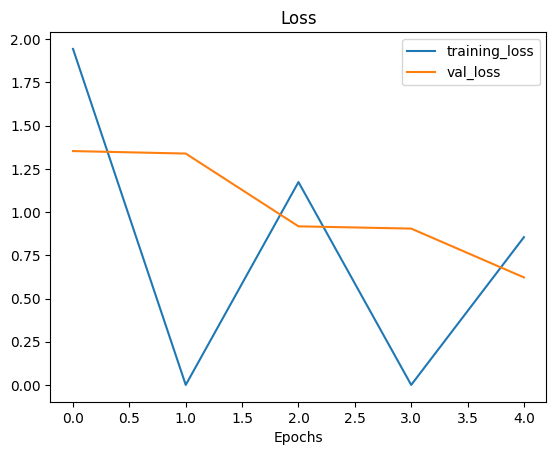

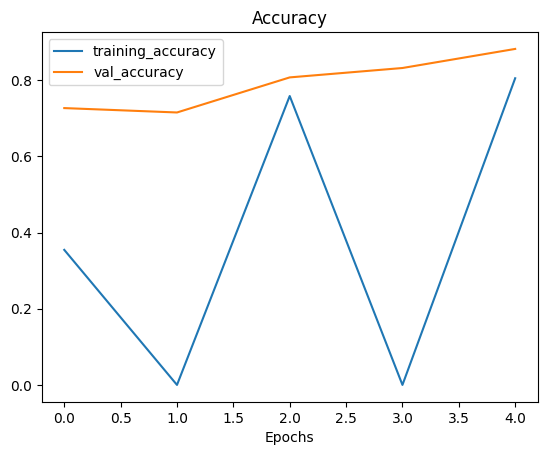

In [19]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)